In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import linprog

from conditionalconformal import CondConf
from fast_soft_sort.pytorch_ops import soft_rank, soft_sort


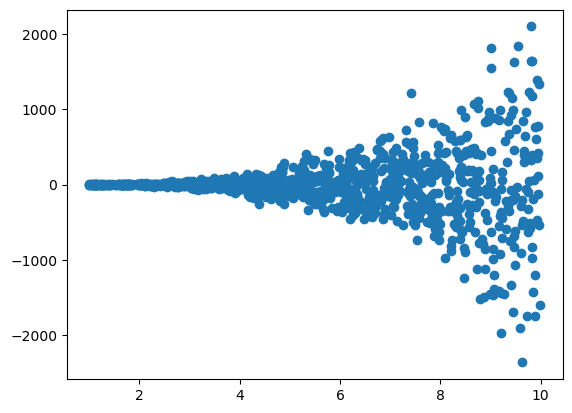

In [404]:
def generate_dataset(rng, n, p):
    x = rng.uniform(low=1, high=10, size=(n,1))
    if p > 1:
        x_noise = rng.uniform(low=5, high=10, size=(n,p - 1))
        x = np.concatenate((x, x_noise), axis=1)
    y = rng.normal(scale=x[:,0]**3)
    return x, y

def split_dataset(dataset, rng, train_frac = 0.8):
    x, y = dataset
    ind = np.arange(len(x))
    rng.shuffle(ind)

    train_num = int(train_frac * len(x))
    train_ind = ind[0:train_num]
    calib_ind = ind[train_num:]
    
    data_train = (x[train_ind], y[train_ind])
    data_calib = (x[calib_ind], y[calib_ind])
    return data_train, data_calib

rng = np.random.default_rng(seed=0)
n = 1000
p = 2

dataset = generate_dataset(rng, n, p)
x, y = dataset
plt.scatter(x[:,0], y)


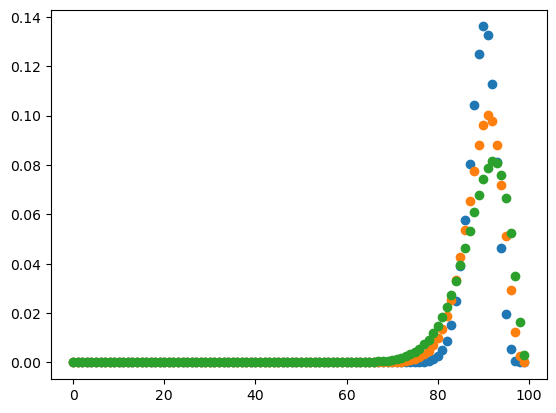

In [301]:
test = np.asarray(np.arange(100))
smooth_quantile(test, 0.9, reg = 1)

smooth_quantile(test, 0.9, reg = 0.5)
smooth_quantile(test, 0.9, reg = 0.3)

from scipy.stats import norm
import math
def normal_weights(n,q,sd = 0.05):
    istar = math.floor(n*q)
    return norm.pdf(np.linspace(0,n,n)/n,loc = istar/n, scale = sd)

In [415]:
def as_tensor(x, dtype, requires_grad=False):
    return torch.tensor(x, dtype=dtype, requires_grad=requires_grad)

beta_opt = np.zeros(p)
beta_opt[0] = 1

def smooth_quantile(x_sorted, q, reg = 1):
    from scipy.special import betainc
    n = len(x_sorted)
    
    betas = betainc(q * reg * (n + 1), (1 - q) * reg * (n + 1), np.linspace(0, 1, n + 1))
    weights = torch.from_numpy(np.diff(betas))
    return torch.sum(weights * x_sorted)

def score_length(beta, dataset, rng, q=0.95, lmbda=1):
    data_train, data_calib = split_dataset(dataset, rng)
    x_train, y_train = data_train
    x_calib, y_calib = data_calib
    
    scores_train = torch.abs(as_tensor(y_train, dtype=beta.dtype)) / torch.abs(as_tensor(x_train, dtype=beta.dtype) @ beta)
    scores_train_sorted = soft_sort(scores_train.reshape(1,-1), regularization_strength=lmbda)
    # cutoff = smooth_quantile(torch.flatten(scores_train_sorted), q * (1 + 1/len(x_train)))
    # cutoff = smooth_quantile(scores_train, q * (1 + 1/len(x_train)))
    cutoff = torch.quantile(scores_train, q * (1 + 1/len(x_train)))

    scores_calib_denom = torch.abs(as_tensor(x_calib, dtype=beta.dtype) @ beta)
    lengths = cutoff * scores_calib_denom
    return torch.mean(lengths)

def estimate_true_error(rng, q, n_eval, p, beta):
    dataset = generate_dataset(rng, n_eval, p)
    data_calib, data_test = split_dataset(dataset, rng, train_frac=0.2)
    x, y = data_calib
    scores = np.abs(y) / np.abs(x @ beta)
    cutoff = np.sort(scores)[int(np.ceil((len(x) + 1) * q))]
    x, y = data_test
    scores_test_denom = np.abs(x @ beta)
    raw_cutoffs = cutoff * scores_test_denom
    lengths = np.mean(raw_cutoffs)

    x, y = data_calib
    scores = np.abs(y) / np.abs(x @ beta_opt)
    cutoff = np.sort(scores)[int(np.ceil((len(x) + 1) * q))]
    x, y = data_test
    scores_test_denom = np.abs(x @ beta_opt)
    raw_cutoffs = cutoff * scores_test_denom

    lengths_opt = np.mean(raw_cutoffs)
    
    return lengths, lengths_opt

torch.manual_seed(1)
beta = torch.tensor(np.asarray([1,0]), dtype=torch.float, requires_grad=True)
print(beta)
optimizer = torch.optim.Adam([beta])

true_lengths = []
obj_lengths = []
n_eval = 10000
for i in tqdm(range(300)):
    rng = np.random.default_rng(seed=i)
    optimizer.zero_grad()
    length = score_length(beta, dataset, rng)
    length.backward()
    optimizer.step()
    obj_lengths.append(length.detach())
    if i % 100 == 0:
        true_error, true_error_baseline = estimate_true_error(rng, 0.95, n_eval, p, beta.detach().numpy())
        print(f"iteration {i}", true_error - true_error_baseline)
        true_lengths.append(true_error - true_error_baseline)
print("final beta", beta)




tensor([1., 0.], requires_grad=True)


  0%|          | 0/300 [00:00<?, ?it/s]

iteration 0 -0.31967991046133193
iteration 100 -22.871733940310605
iteration 200 -27.753089174719662
final beta tensor([ 0.8402, -0.1164], requires_grad=True)


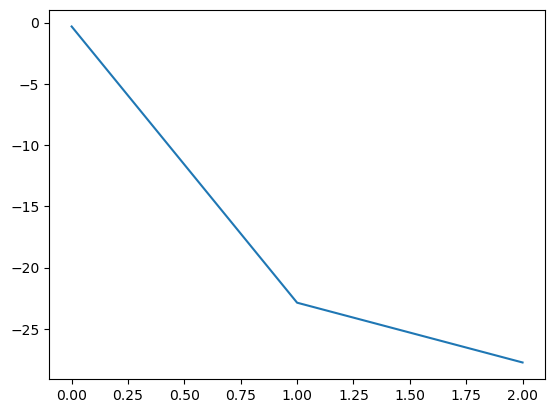

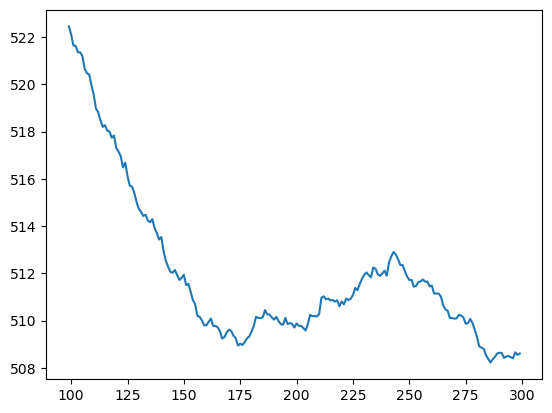

In [416]:
# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Parameters
window_size = 10  # Size of the moving window

# Compute the moving average
ma = moving_average(true_lengths, window_size)
# plt.plot(np.arange(window_size - 1, len(true_lengths)), ma)
plt.plot(np.arange(len(true_lengths)), true_lengths)

plt.figure()
window_size = 100  # Size of the moving window

ma = moving_average(obj_lengths, window_size)
plt.plot(np.arange(window_size - 1, len(obj_lengths)), ma)
# plt.plot(np.arange(len(obj_lengths)), obj_lengths)

In [417]:
def get_current_basis(primals, duals, Phi, S, quantile):
    interp_bools = np.logical_and(~np.isclose(duals, quantile - 1),~np.isclose(duals, quantile))
    if np.sum(interp_bools) == Phi.shape[1]:
        return interp_bools
    preds = (Phi @ primals).flatten()
    active_indices = np.where(interp_bools)[0]
    interp_indices = np.argsort(np.abs(S - preds))[0:Phi.shape[1]]
    diff_indices = np.setdiff1d(interp_indices, active_indices)
    num_missing = Phi.shape[1] - np.sum(interp_bools)
    if num_missing < len(diff_indices):
        from itertools import combinations
        for cand_indices in combinations(diff_indices, num_missing):
            cand_phi = Phi[np.concatenate((active_indices, cand_indices))]
            if np.isfinite(np.linalg.cond(cand_phi)):
                interp_bools[np.asarray(cand_indices)] = True
                break
    else:
        interp_bools[diff_indices] = True
    return interp_bools
            
def solve_qr(Phi, s, q, dtype):
    S = s.detach().numpy()
    zeros = np.zeros((Phi.shape[1],))
    bounds = [(q - 1, q)] * len(S)
    res = linprog(-1 * S, A_eq=Phi.T, b_eq=zeros, bounds=bounds,
                    method='highs-ds', options={'presolve': False})

    tau = -1 * res.eqlin.marginals

    basis = get_current_basis(tau, res.x, Phi, S, q)
    
    tau = as_tensor(np.linalg.inv(Phi[basis].T @ Phi[basis]) @ Phi[basis].T, dtype=dtype) @ s[basis]
    return tau.reshape(-1,1)
    
def cond_score_length(beta, dataset, rng, q=0.95):
    data_train, data_calib = split_dataset(dataset, rng)
    x_train, y_train = data_train
    x_calib, y_calib = data_calib
        
    scores_train = torch.abs(as_tensor(y_train, dtype=beta.dtype)) / torch.abs(as_tensor(x_train, dtype=beta.dtype) @ beta)

    Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
    # scores_aug = torch.cat((scores_train, torch.tensor([1e5])))
    # cutoffs = torch.zeros((len(x_calib),), dtype=beta.dtype)
    # for i, x_c in enumerate(x_calib):
    #     x_aug = np.concatenate((x_train, x_c.reshape(1,-1)), axis=0)
    #     tau = solve_qr(x_aug, scores_aug, q, beta.dtype)
    #     phi_c = np.concatenate((np.asarray([1]), x_c))
    #     cutoffs[i] = as_tensor(phi_c, dtype=beta.dtype) @ tau
    #     break
    
    # replace cutoff computation with quantile regression
    phi_train = Phi_fn(x_train)
    tau = solve_qr(phi_train, scores_train, q, beta.dtype)

    phi_calib = Phi_fn(x_calib)
    cutoffs = torch.flatten(as_tensor(phi_calib, dtype=beta.dtype) @ tau)

    lengths = cutoffs * torch.abs(as_tensor(x_calib, dtype=beta.dtype) @ beta)
    return torch.mean(lengths), (x_calib, cutoffs), tau


def estimate_true_error_cond(rng, q, n_eval, p, beta):
    dataset = generate_dataset(rng, n_eval, p)
    data_calib, data_test = split_dataset(dataset, rng, train_frac=0.2)
    x, y = data_calib
    x_test, y_test = data_test
    condconf = CondConf(
        score_fn = lambda x, y: np.abs(y) / np.abs(x @ beta),
        Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
    )
    condconf.setup_problem(x, y)
    raw_cutoffs = []
    for x_t in x_test:
        raw_cutoff = condconf.predict(0.95, x_t.reshape(1,-1), score_inv_fn = lambda cutoff, x: cutoff * np.abs(x.T @ beta))
        raw_cutoffs.append(raw_cutoff)
    raw_cutoffs = np.asarray(raw_cutoffs).flatten()

    lengths = np.mean(raw_cutoffs)

    condconf = CondConf(
        score_fn = lambda x, y: np.abs(y) / np.abs(x @ beta_opt),
        Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
    )
    condconf.setup_problem(x, y)
    raw_cutoffs = []
    for x_t in x_test:
        raw_cutoff = condconf.predict(0.95, x_t.reshape(1,-1), score_inv_fn = lambda cutoff, x: cutoff * np.abs(x.T @ beta_opt))
        raw_cutoffs.append(raw_cutoff)
    raw_cutoffs = np.asarray(raw_cutoffs).flatten()

    lengths_opt = np.mean(raw_cutoffs)
    
    return lengths, lengths_opt


beta_cond = torch.tensor(np.asarray([1,0]), dtype=torch.float, requires_grad=True)
print(beta_cond)
optimizer = torch.optim.Adam([beta_cond])

obj_lengths = []
true_lengths = []
n_eval = 1000
for i in tqdm(range(300)):
    optimizer.zero_grad()
    length, (x_calib, cutoffs), tau = cond_score_length(beta_cond, dataset, rng)
    length.backward()
    optimizer.step()
    obj_lengths.append(length.detach())
    if i % 1000 == 0 and i > 0:
        true_error, true_error_baseline = estimate_true_error_cond(rng, 0.95, n_eval, p, beta_cond.detach().numpy())
        print(f"iteration {i}", true_error - true_error_baseline)
        true_lengths.append(true_error - true_error_baseline)
print(beta_cond, length)

tensor([1., 0.], requires_grad=True)


  0%|          | 0/300 [00:00<?, ?it/s]

tensor([ 0.9866, -0.0157], requires_grad=True) tensor(557.6927, grad_fn=<MeanBackward0>)


In [410]:
# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Parameters
window_size = 10  # Size of the moving window

# Compute the moving average
ma = moving_average(true_lengths, window_size)
# plt.plot(np.arange(window_size - 1, len(true_lengths)), ma)
plt.plot(np.arange(len(true_lengths)), true_lengths)

plt.figure()
window_size = 100  # Size of the moving window

ma = moving_average(obj_lengths, window_size)
plt.plot(np.arange(window_size - 1, len(obj_lengths)), ma)
# plt.plot(np.arange(len(obj_lengths)), obj_lengths)

ValueError: v cannot be empty

Optimized beta [ 0.98664    -0.01573705]


  0%|          | 0/1000 [00:00<?, ?it/s]

Optimized beta [ 0.8402255  -0.11638542]
Length 560.1645933788163


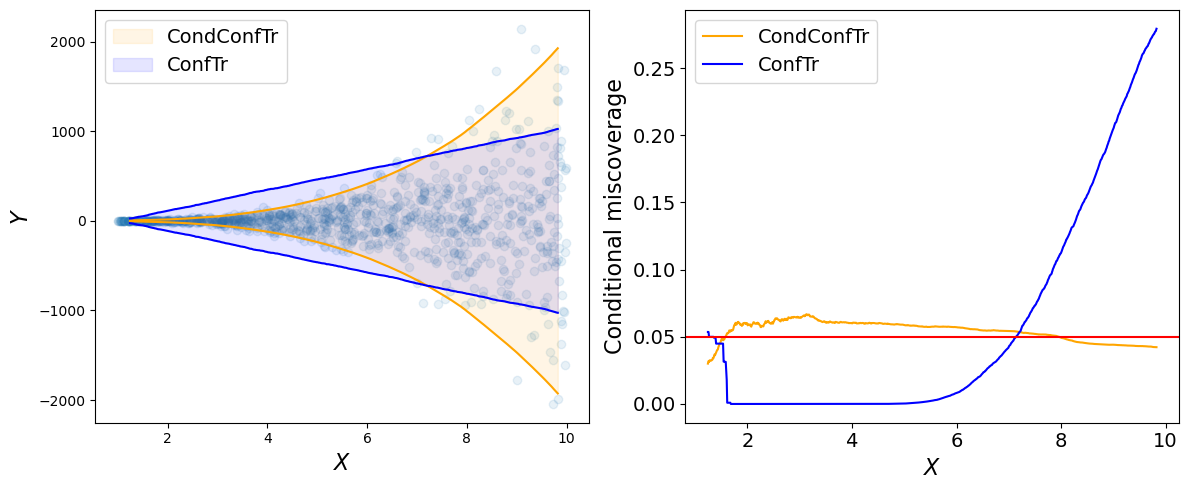

In [457]:
# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Parameters
window_size = 50  # Size of the moving window

from scipy.stats import norm

rng = np.random.default_rng(seed=123)
n = 2000
dataset = generate_dataset(rng, n, p) 
data_calib, data_test = split_dataset(dataset, rng, train_frac=0.5)

x, y = data_calib

beta_val = beta_cond.detach().numpy()
print("Optimized beta", beta_val)
# beta_val = np.asarray([1.,0.])
scores = np.abs(y) / np.abs(x @ beta_val)

x_test, y_test = data_test
sorted_ind = np.argsort(x_test[:,0])

# get actual intervals from condconf
condconf = CondConf(
    score_fn = lambda x, y: np.abs(y) / np.abs(x @ beta_val),
    Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
)
condconf.setup_problem(x, y)
raw_cutoffs = []
for x_t in tqdm(x_test[sorted_ind]):
    raw_cutoff = condconf.predict(0.95, x_t.reshape(1,-1), score_inv_fn = lambda cutoff, x: cutoff * np.abs(x.T @ beta_val))
    raw_cutoffs.append(raw_cutoff)
raw_cutoffs = np.asarray(raw_cutoffs).flatten()

# plot conditional-optimized prediction set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x_test[:,0], y_test, alpha=0.1)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylabel(f"$Y$", fontsize=16)
ax1.set_xlabel(f"$X$", fontsize=16)
ma_x = moving_average(x_test[sorted_ind,0], window_size)
ma_ub = moving_average(raw_cutoffs, window_size)
ma_lb = -1 * ma_ub
ax1.plot(ma_x, ma_ub, color='orange')
ax1.plot(ma_x, ma_lb, color='orange')
ax1.fill_between(ma_x, ma_lb, ma_ub, color='orange', alpha=0.1, label="CondConfTr")

# plot marginal-optimized prediction set

beta_val = beta.detach().numpy()
print("Optimized beta", beta_val)
scores = np.abs(y) / np.abs(x @ beta_val)

cutoff = np.sort(scores)[int(np.ceil((len(x) + 1) * 0.95))]


raw_cutoff = cutoff * np.abs(x_test[sorted_ind] @ beta.detach().numpy())
ma_ub_bad = moving_average(raw_cutoff, window_size)
ma_lb_bad = -1 * ma_ub_bad

ax1.plot(ma_x, ma_ub_bad, color='blue')
ax1.plot(ma_x, ma_lb_bad, color='blue')
ax1.fill_between(ma_x, ma_lb_bad, ma_ub_bad, color='blue', alpha=0.1, label="ConfTr")

print("Length", np.mean(raw_cutoffs))
ax1.legend(fontsize=14)

pointwise_miscover = (1 - norm.cdf(raw_cutoffs, scale=x_test[sorted_ind,0]**3)) * 2
pointwise_miscover_bad = (1 - norm.cdf(raw_cutoff, scale=x_test[sorted_ind,0]**3)) * 2

# Compute the moving average
ma_y = moving_average(pointwise_miscover, window_size)
ma_y_bad = moving_average(pointwise_miscover_bad, window_size)

ax2.plot(ma_x, ma_y, color='orange', label="CondConfTr")
ax2.plot(ma_x, ma_y_bad, color='blue', label="ConfTr")
# plt.scatter(x_test[sorted_ind,0], (1 - norm.cdf(raw_cutoffs, scale=x_test[sorted_ind,0])) * 2, alpha=0.01)

ax2.axhline(0.05, color='red')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel(f"$X$", fontsize=16)
ax2.set_ylabel("Conditional miscoverage", fontsize=16)
ax2.legend(fontsize=14)
plt.tight_layout()
plt.savefig("figures/boost_synthetic_comparison.pdf")

  0%|          | 0/1000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


566.8665803212532


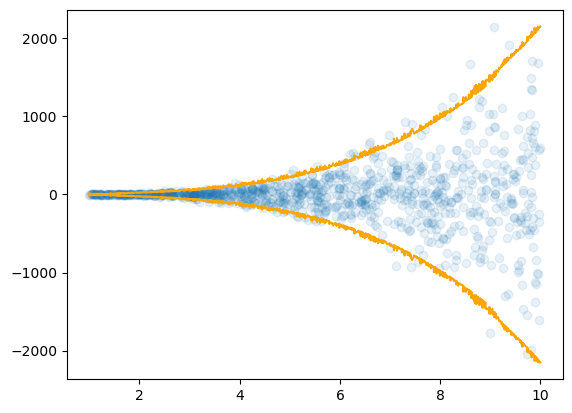

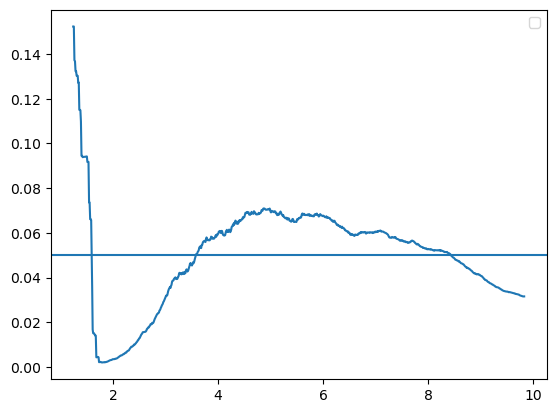

In [455]:
# get actual intervals from condconf
condconf = CondConf(
    score_fn = lambda x, y: np.abs(y) / np.abs(x @ beta.detach().numpy()),
    Phi_fn = lambda x: np.concatenate((np.ones((len(x), 1)), x, x**2), axis=1)
)
condconf.setup_problem(x, y)
raw_cutoffs = []
for x_t in tqdm(x_test[sorted_ind]):
    raw_cutoff = condconf.predict(0.95, x_t.reshape(1,-1), score_inv_fn = lambda cutoff, x: cutoff * np.abs(x.T @ beta.detach().numpy()))
    raw_cutoffs.append(raw_cutoff)
raw_cutoffs = np.asarray(raw_cutoffs).flatten()
plt.scatter(x_test[:,0], y_test, alpha=0.1)
plt.plot(x_test[sorted_ind,0], raw_cutoffs, color='orange')
plt.plot(x_test[sorted_ind,0], -1 * raw_cutoffs, color='orange')
print(np.mean(raw_cutoffs))

pointwise_miscover_test = (1 - norm.cdf(raw_cutoffs, scale=x_test[sorted_ind,0]**3)) * 2
ma_y = moving_average(pointwise_miscover_test, window_size)
plt.figure()
plt.plot(ma_x, ma_y)
plt.legend()
plt.axhline(0.05)